In [7]:
import json
import matplotlib.pyplot as plt
from collections import Counter



def plot_histograms(projects):
    contributors_per_project(projects)
    projects_per_contributor(projects)
    prestige_per_project(projects)
    completion_per_project(projects)
    quality_per_project(projects)

def contributors_per_project(projects):
    # Extract project IDs and contributor counts
    project_ids = [p["project_id"] for p in projects]
    num_contributors = [len(p["contributors"]) for p in projects]
    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.hist(num_contributors, bins=range(1, max(num_contributors) + 2), edgecolor="black", align="left")
    plt.xlabel("Number of Contributors")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Contributors per Project")
    plt.xticks(range(1, max(num_contributors) + 1))
    plt.tight_layout()
    plt.show()

def projects_per_contributor(projects):
    # Flatten all contributors into one list
    all_contributors = []
    for p in projects:
        all_contributors.extend(p["contributors"])

    # Count number of projects per contributor
    author_counts = Counter(all_contributors)

    # Count how many authors fall into each "papers per author" category
    papers_per_author = list(author_counts.values())
    distribution = Counter(papers_per_author)

    # Sort bins by number of papers
    bins = sorted(distribution.keys())
    authors_in_bins = [distribution[b] for b in bins]

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(bins, authors_in_bins, width=0.8, edgecolor="black")
    plt.xlabel("Number of Papers per Author")
    plt.ylabel("Number of Authors")
    plt.title("Authors by Number of Papers")
    plt.xticks(bins)  # discrete ticks at bin centers
    plt.tight_layout()
    plt.show()

def prestige_per_project(projects):
        # Compute prestige category for each project
    prestige_categories = [int(p["project_id"].split("-")[1]) % 3 for p in projects]

    # Count projects per category
    category_counts = Counter(prestige_categories)

    # Sort categories for plotting
    categories = sorted(category_counts.keys())
    counts = [category_counts[c] for c in categories]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.bar(categories, counts, width=0.6, edgecolor="black")
    plt.xlabel("Prestige Category (mod 3)")
    plt.ylabel("Number of Projects")
    plt.title("Projects per Prestige Category")
    plt.xticks(categories)
    plt.tight_layout()
    plt.show()

def completion_per_project(projects):
    # Compute completion percentage per project
    project_ids = [p["project_id"] for p in projects]
    completion = [
        (p["current_effort"] / p["required_effort"]) * 100
        for p in projects
    ]

    # Plot histogram with bins (0–100 in steps of 10)
    plt.figure(figsize=(8, 5))
    plt.hist(completion, bins=range(0, 110, 10), edgecolor="black", align="left")
    plt.xlabel("Completion (%)")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Completion")
    plt.xticks(range(0, 110, 10))
    plt.tight_layout()
    plt.show()

def quality_per_project(projects):
        # Extract quality scores
    quality_scores = [p["quality_score"] for p in projects]

    # Plot histogram (bins of 0.1 from 0 to 1)
    plt.figure(figsize=(8, 5))
    plt.hist(quality_scores, bins=[i/10 for i in range(0, 11)], edgecolor="black", align="mid")
    plt.xlabel("Quality Score")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Quality Scores")
    plt.xticks([i/10 for i in range(0, 11)])
    plt.tight_layout()
    plt.show()

In [11]:
# Load projects list from JSON file
with open("../log/policy_all_careerist_projects.json", "r") as f:
    all_careerist_projects = json.load(f)


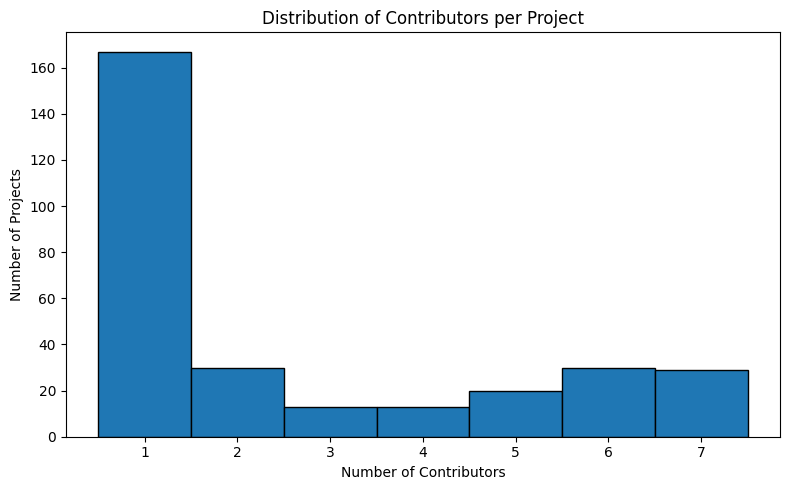

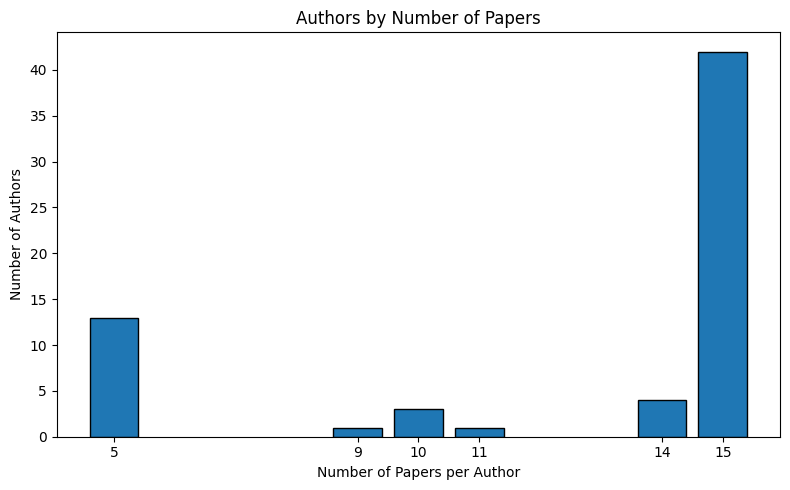

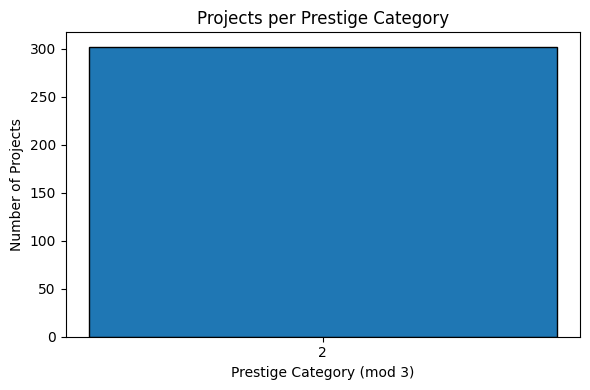

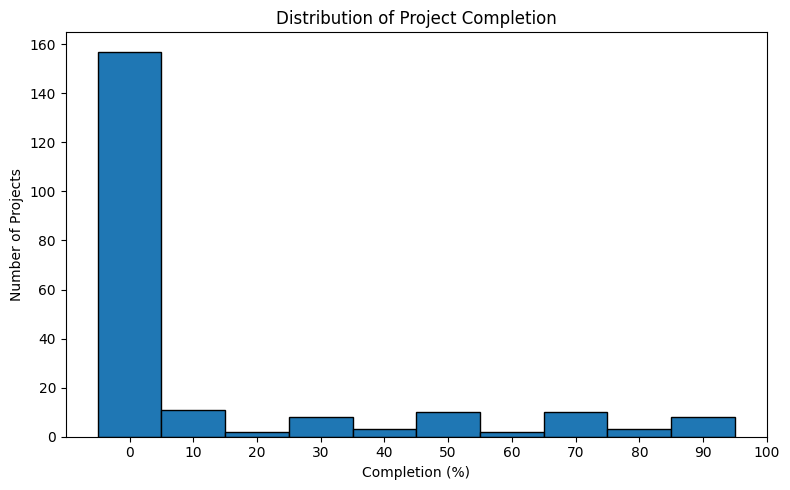

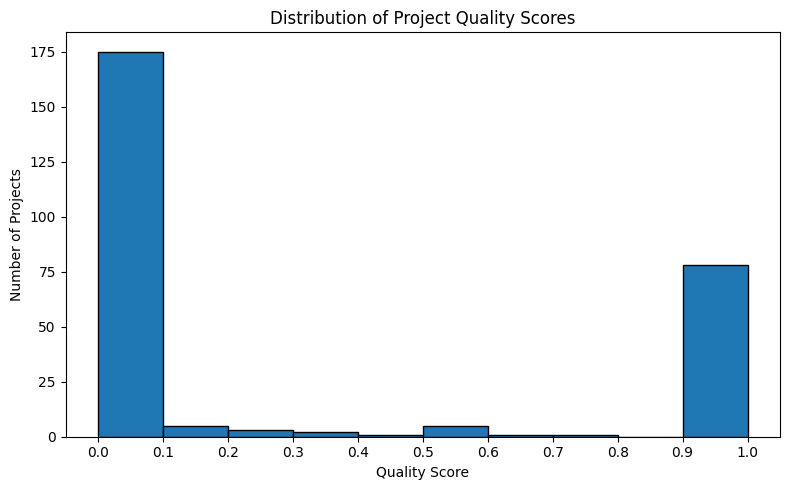

In [12]:
plot_histograms(all_careerist_projects)

In [13]:
# Load projects list from JSON file
with open("../log/policy_all_orthodox_projects.json", "r") as f:
    all_orthodox_projects = json.load(f)

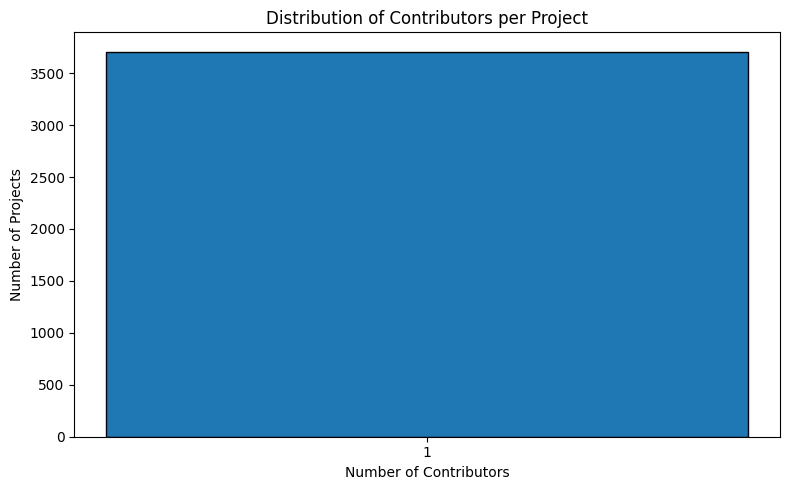

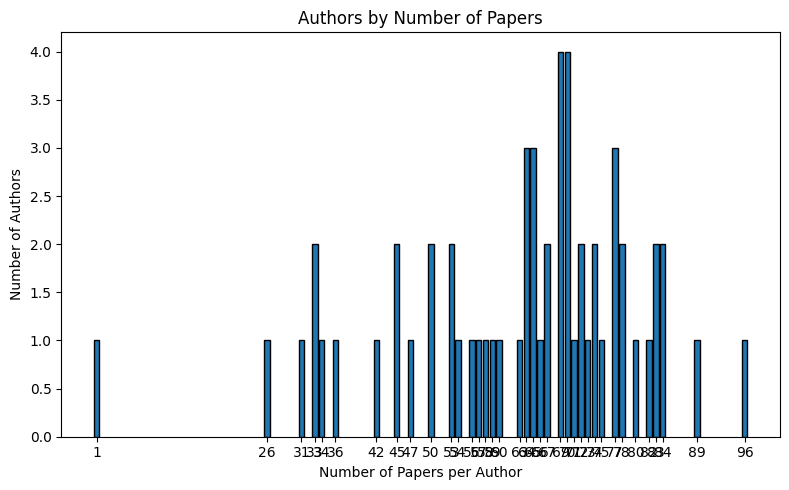

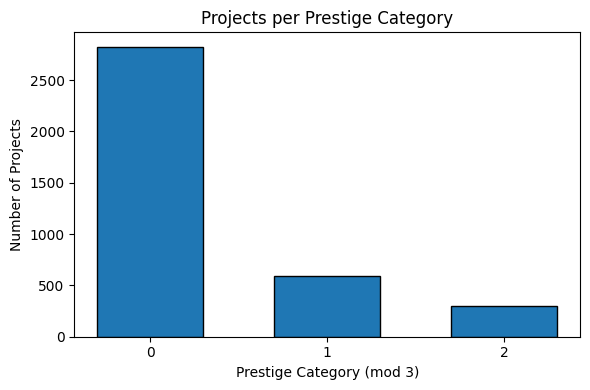

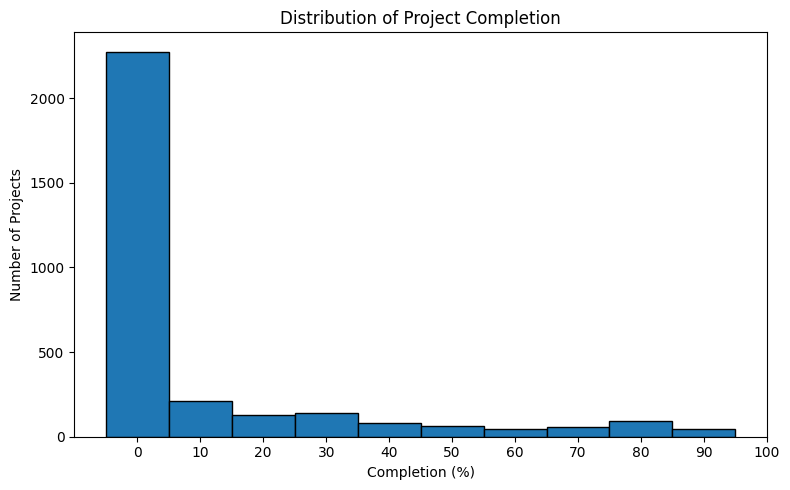

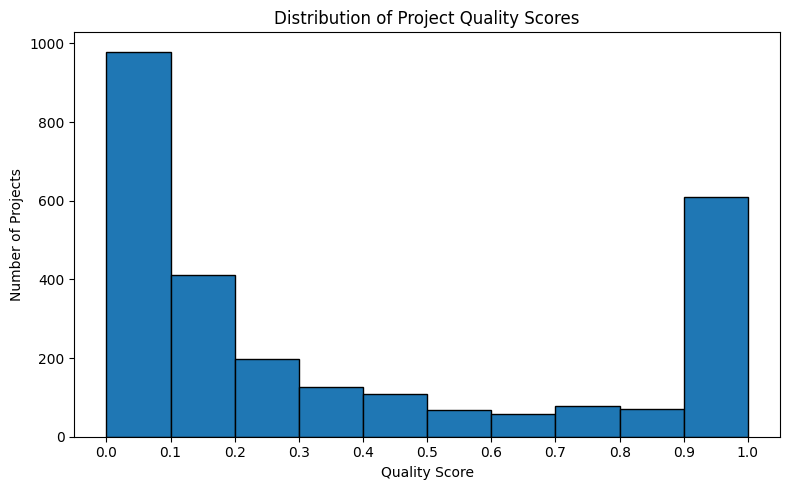

In [14]:

plot_histograms(all_orthodox_projects)

In [16]:

# Load projects list from JSON file
with open("../log/policy_all_orthodox_projects.json", "r") as f:
    all_mass_producer_projects = json.load(f)

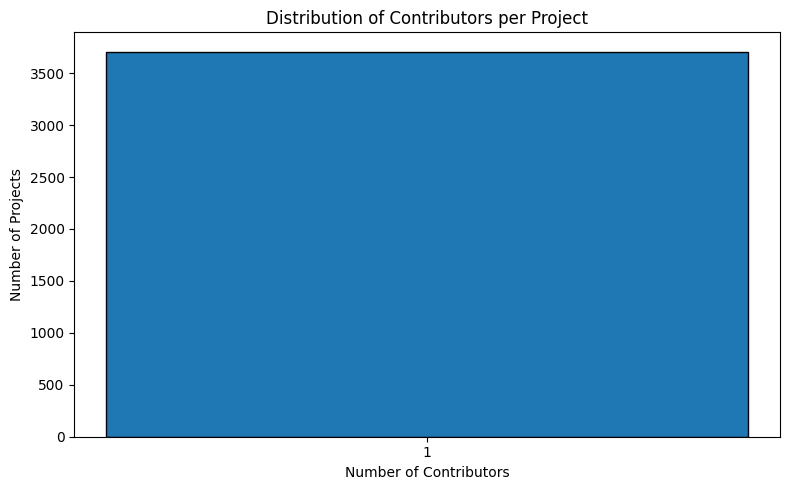

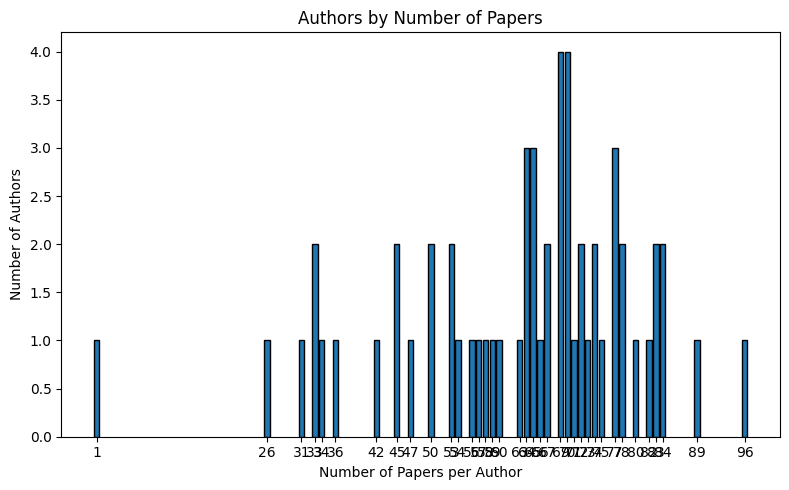

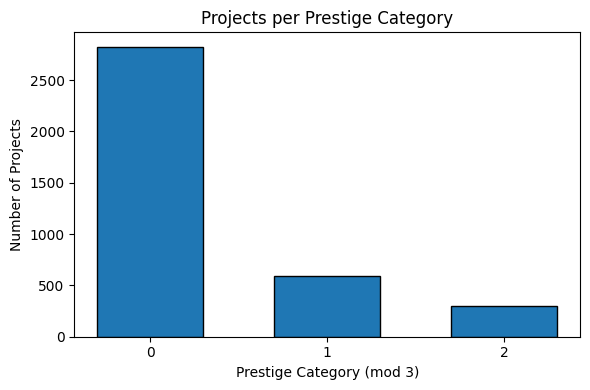

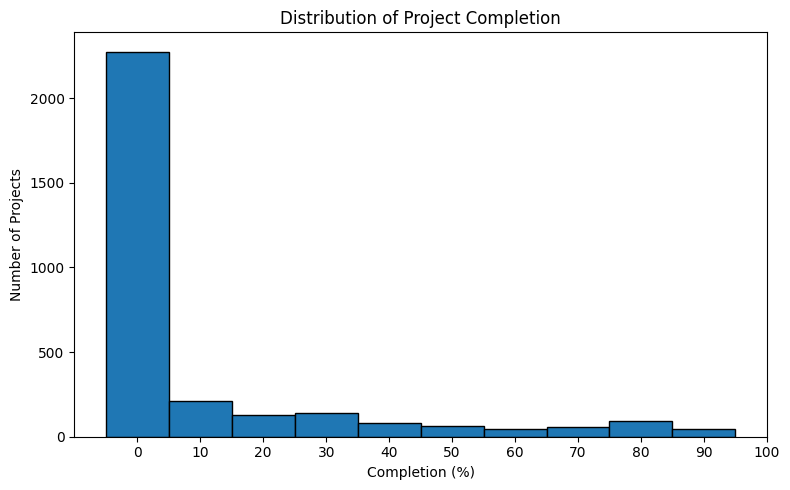

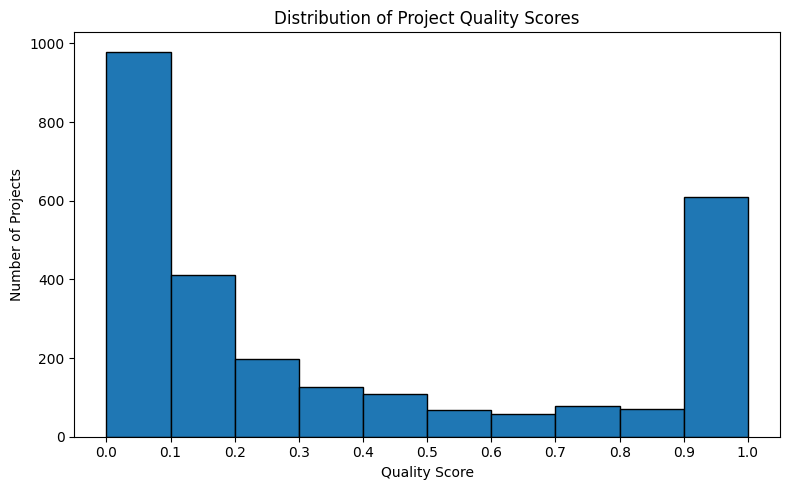

In [17]:
plot_histograms(all_mass_producer_projects)

In [18]:

# Load projects list from JSON file
with open("../log/policy_balanced_projects.json", "r") as f:
    balanced_projects = json.load(f)

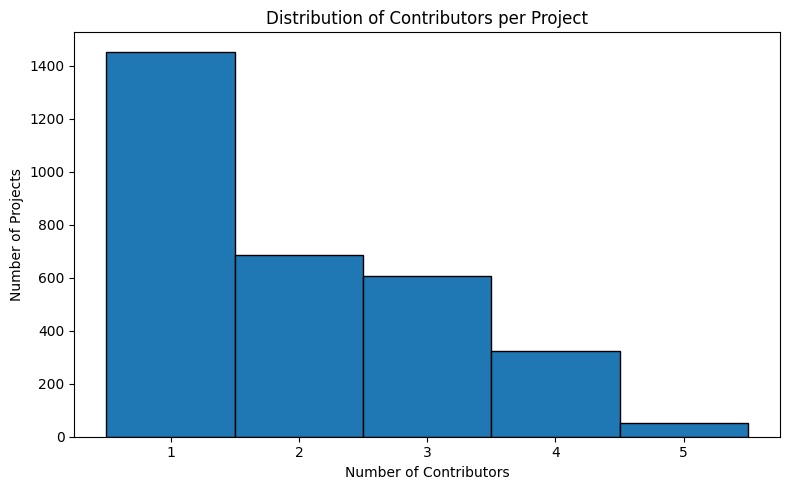

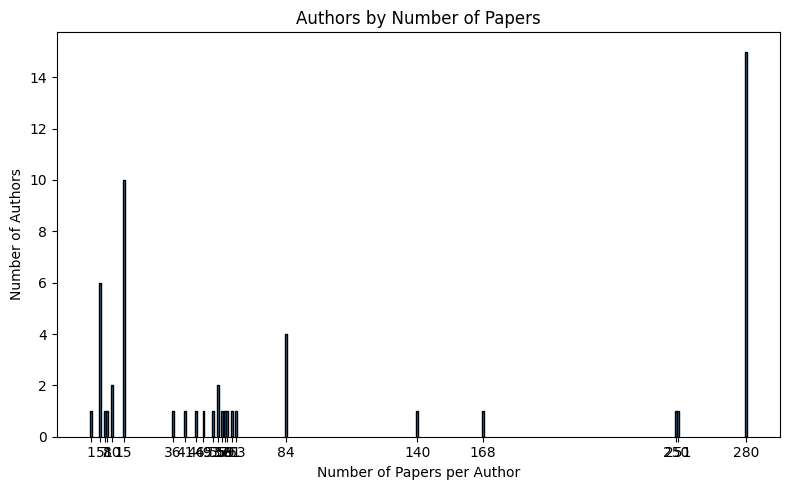

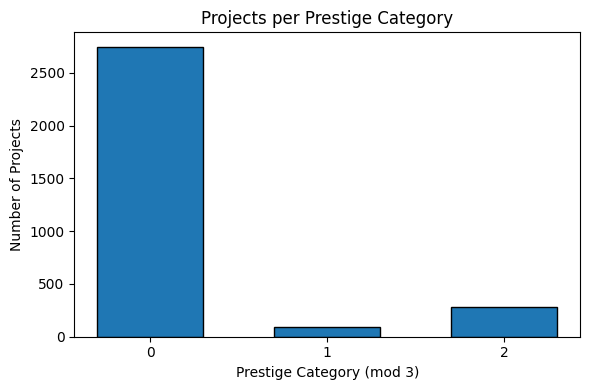

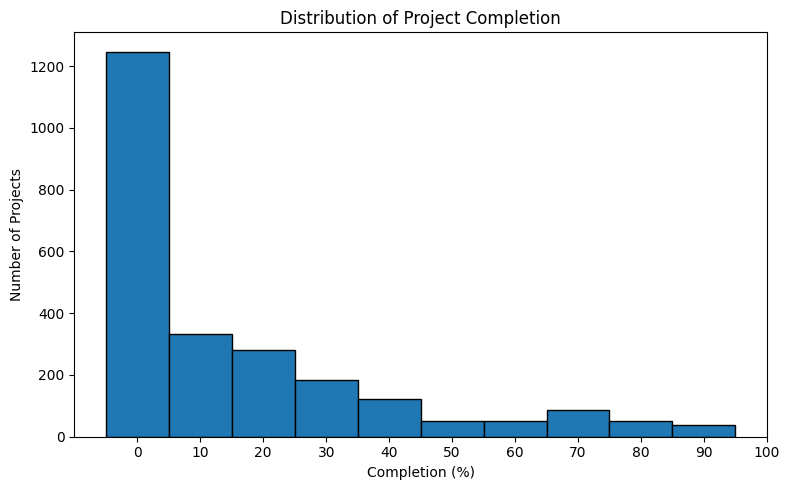

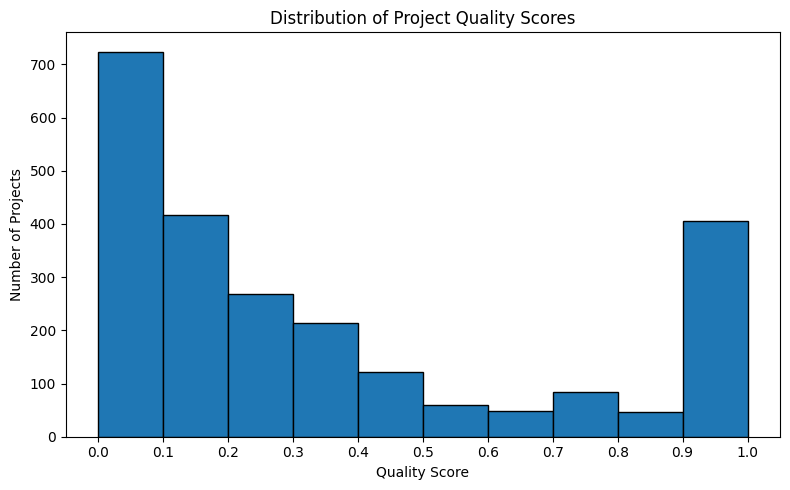

In [19]:
plot_histograms(balanced_projects)

In [20]:
# Load projects list from JSON file
with open("../log/policy_careerist_heavy_projects.json", "r") as f:
    careerist_heavy_projects = json.load(f)

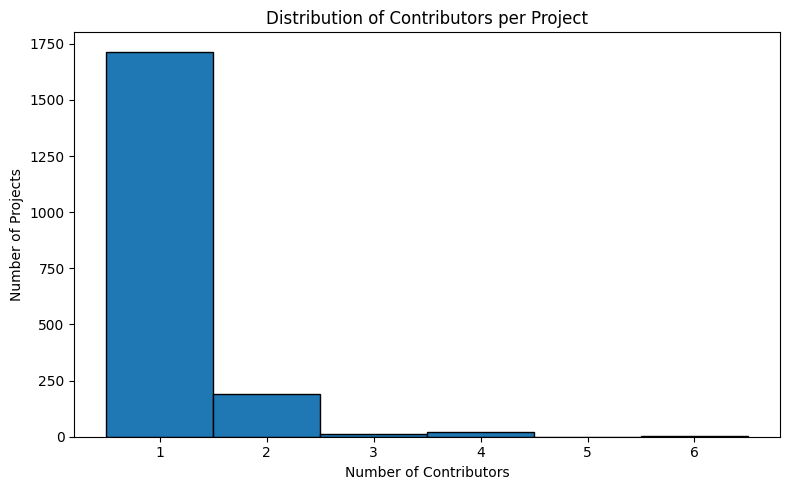

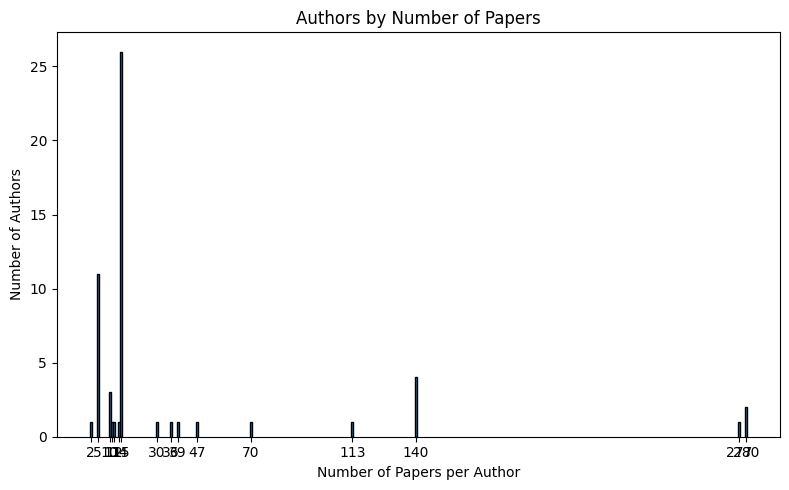

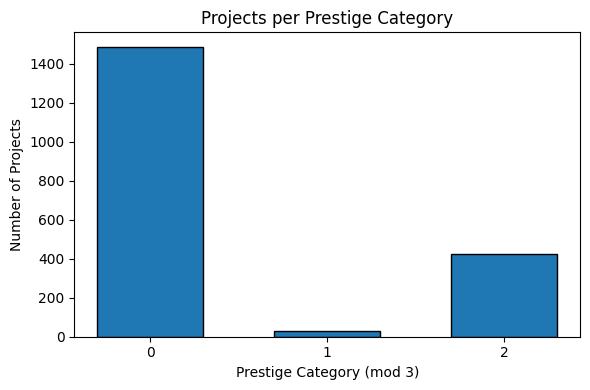

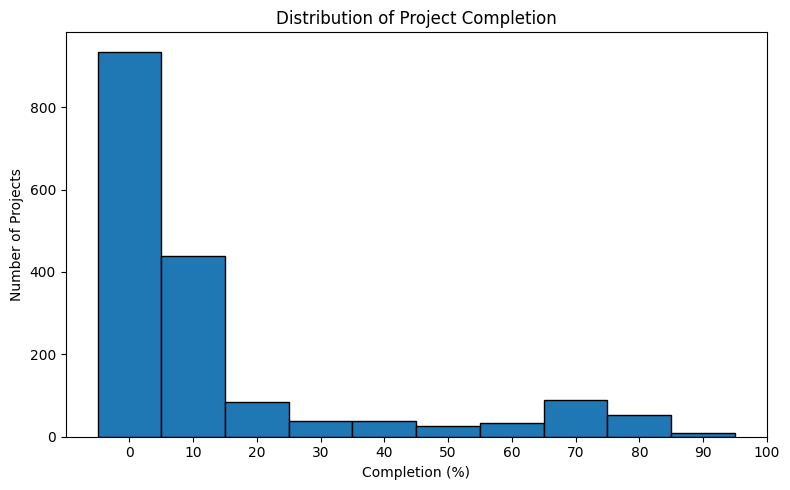

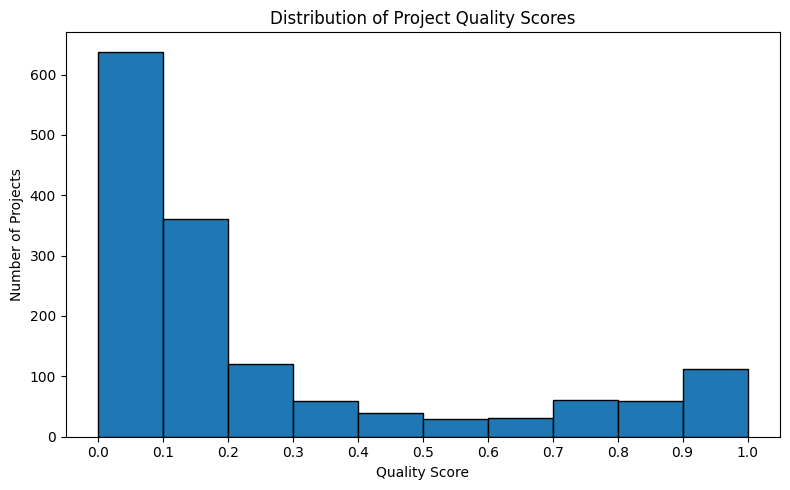

In [21]:
plot_histograms(careerist_heavy_projects)

In [22]:
# Load projects list from JSON file
with open("../log/policy_orthodox_heavy_projects.json", "r") as f:
    orthodox_heavy_projects = json.load(f)

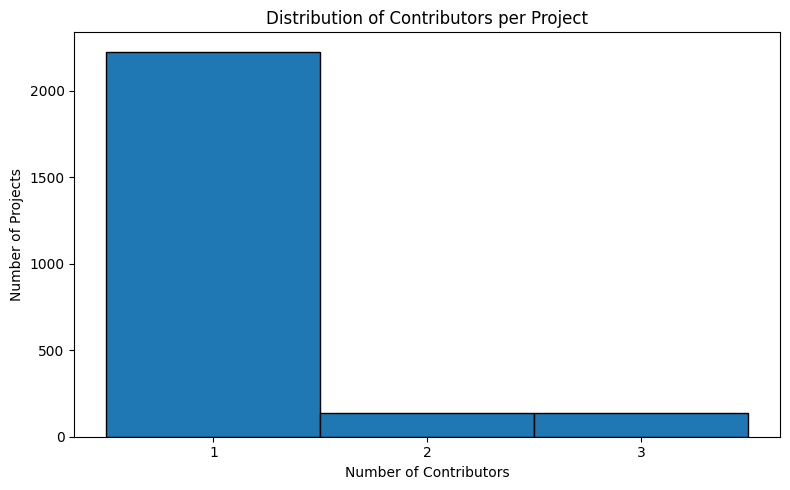

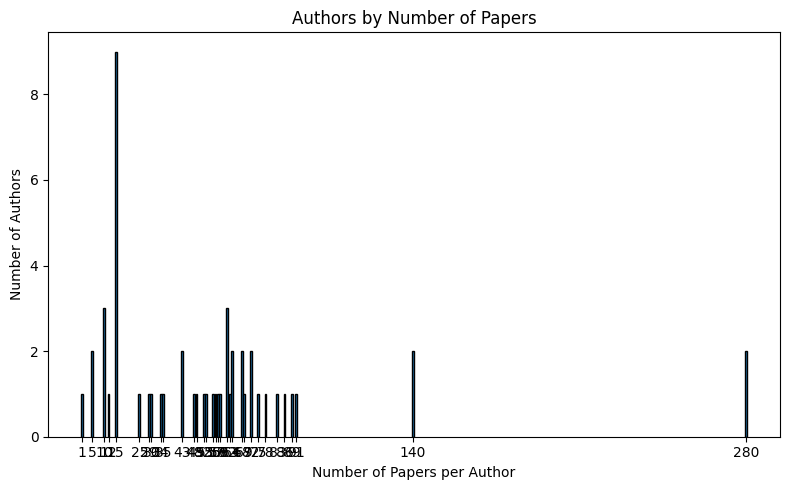

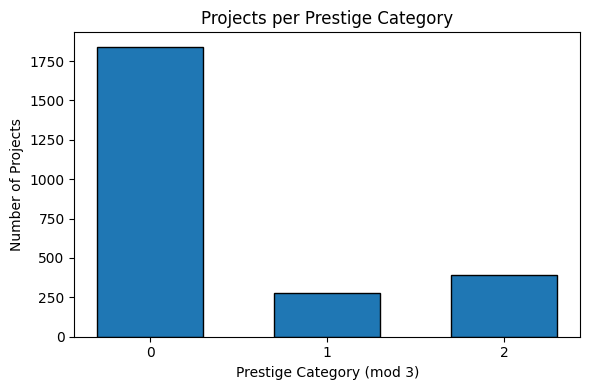

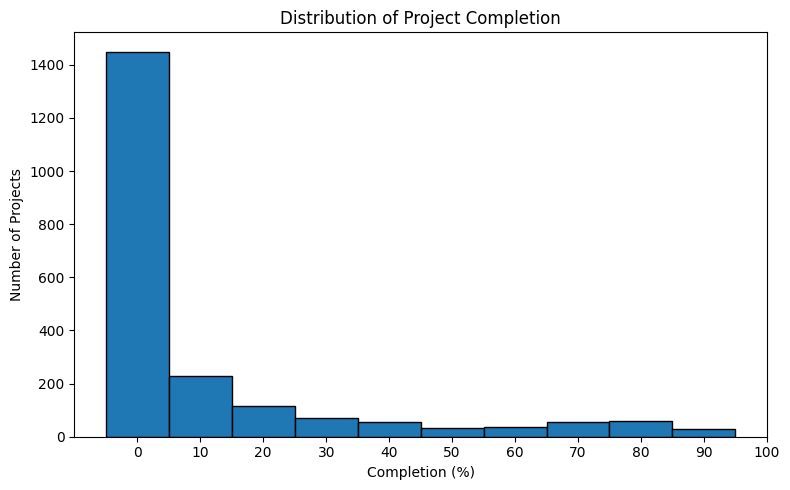

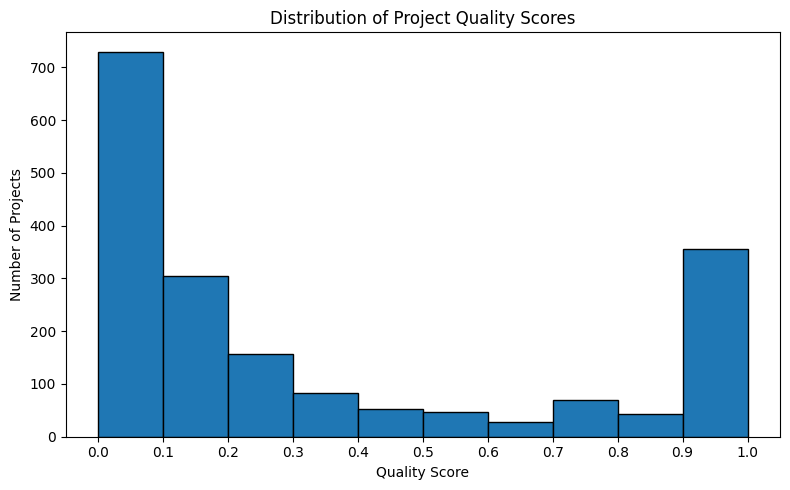

In [23]:
plot_histograms(orthodox_heavy_projects)